<a href="https://www.kaggle.com/code/hoale2908/mortgage-loan-default-data-preprocessing?scriptVersionId=197717220" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
        
data = pd.read_csv('/kaggle/input/loan-default-dataset/Loan_Default.csv')

# Pipeline
* Understand the features and remove unnecessary features
* Detect duplicates, missing values, and outliers
* Imputation using appropriate techniques
    * Remove duplicates
    * Estimate the values of outliers 
    * Impute missing values

# Understand the features

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [3]:
# Unique values of each categorical feature:

for col in data.columns:
    if data[col].dtypes == object:
        print(col + ' ' + '-'*(30-len(col)) + ' ', data[col].unique())
    else:
        pass

loan_limit --------------------  ['cf' nan 'ncf']
Gender ------------------------  ['Sex Not Available' 'Male' 'Joint' 'Female']
approv_in_adv -----------------  ['nopre' 'pre' nan]
loan_type ---------------------  ['type1' 'type2' 'type3']
loan_purpose ------------------  ['p1' 'p4' 'p3' 'p2' nan]
Credit_Worthiness -------------  ['l1' 'l2']
open_credit -------------------  ['nopc' 'opc']
business_or_commercial --------  ['nob/c' 'b/c']
Neg_ammortization -------------  ['not_neg' 'neg_amm' nan]
interest_only -----------------  ['not_int' 'int_only']
lump_sum_payment --------------  ['not_lpsm' 'lpsm']
construction_type -------------  ['sb' 'mh']
occupancy_type ----------------  ['pr' 'sr' 'ir']
Secured_by --------------------  ['home' 'land']
total_units -------------------  ['1U' '2U' '3U' '4U']
credit_type -------------------  ['EXP' 'EQUI' 'CRIF' 'CIB']
co-applicant_credit_type ------  ['CIB' 'EXP']
age ---------------------------  ['25-34' '55-64' '35-44' '45-54' '65-74' '>74' '<2

**Understanding some abbreviations and their meaning:**
* Loan limit: CF (conforming) or NCF (non-conforming). Conforming loans meet the criteria for purchases by Fannie Mae or Freddie Mac to issue MBS, thus usually have lower interest or downpayment. ([source](https://www.quickenloans.com/learn/what-is-a-conforming-loan))
* Approveal in advance (approv_in_adv): as the name suggests.
* Open credit: whether the borrower is allowed to borrow more money.
* Neg ammortization: A negative amortization loan is one in which unpaid interest is added to the balance of unpaid principal. ([source](https://www.investopedia.com/terms/n/negativeamortization.asp)) 
* Construction type: SB (splash block) or MH (manhole)
* Occupancy type: PR, SR, and IR refer to primary, secondary and investment. Financial risks increase with the latter ones, so do interest rates. ([soure](https://www.homelendingpal.com/how-mortgage-lenders-determine-interest-rates-based-on-occupancy-types/))
* Credit type: EXP = Experian, EQUI = Equifax, CRIF = CRIF Highmark, CIB = CIBIL. These are different credit reporting agencies. The main differences come down to the credit score calculations used and how they process information. ([source](https://www.chase.com/personal/credit-cards/education/credit-score/credit-bureau-differences) and [source](https://en.wikipedia.org/wiki/Credit_bureau))
* Submission of application: *to_inst* seems to refer to a special method for loan approval, i.e. instance-based method. Read more at ([source](https://www.sciencedirect.com/science/article/pii/S0957417421002396)).
* Security type: Direct or Indirect. Direct security means the borrower uses the mortgaged house to pledge against the loan. ([source](https://corporatefinanceinstitute.com/resources/commercial-lending/direct-security/#:~:text=To%20conclude%2C%20direct%20securities%20are,the%20borrower%20default%20on%20it.))


**Remove unnecessary features:**

Some features are not very helpful in predicting default, so they should be removed from the dataset to save us time from analyzing and modifying them.

In [4]:
# Remove features that do not have significant impact on default

loan = data.copy()
loan.drop(columns=['ID' ,'loan_limit' ,'Gender', 'construction_type', 'Secured_by', 'total_units', \
                   'credit_type', 'co-applicant_credit_type', 'Region', 'Neg_ammortization', 'year', \
                   'submission_of_application' , 'approv_in_adv'], 
          axis=1, inplace=True)

loan.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,property_value,income,Credit_Score,LTV,Status,dtir1
count,1.486700e+05,112231.000000,112031.000000,109028.000000,148629.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,148670.000000,124549.000000
mean,3.311177e+05,4.045476,0.441656,3224.996127,335.136582,4.978935e+05,6957.338876,699.789103,72.746457,0.246445,37.732932
std,1.839093e+05,0.561391,0.513043,3251.121510,58.409084,3.599353e+05,6496.586382,115.875857,39.967603,0.430942,10.545435
min,1.650000e+04,0.000000,-3.638000,0.000000,96.000000,8.000000e+03,0.000000,500.000000,0.967478,0.000000,5.000000
25%,1.965000e+05,3.625000,0.076000,581.490000,360.000000,2.680000e+05,3720.000000,599.000000,60.474860,0.000000,31.000000
50%,2.965000e+05,3.990000,0.390400,2596.450000,360.000000,4.180000e+05,5760.000000,699.000000,75.135870,0.000000,39.000000
75%,4.365000e+05,4.375000,0.775400,4812.500000,360.000000,6.280000e+05,8520.000000,800.000000,86.184211,0.000000,45.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,360.000000,1.650800e+07,578580.000000,900.000000,7831.250000,1.000000,61.000000


# Detect duplicates, missing values, and outliers

**Structure of the dataset with regard to target feature:**

In [5]:
#Number of defaulted loans
loan['Status'].sum()

36639

Over 36,000 loans or almost 25% of the dataset are defaults (mean value of Status). The dataset is imbalance but not significantly. 

**Remove duplicates:**

In [6]:
# Checking for duplicates

print('Number of duplicated records: ', len(loan[loan.duplicated() == True]))

# Remove duplicates and double check

loan = loan.drop_duplicates()
print('Number of duplicated records (updated): ', len(loan[loan.duplicated() == True]))

Number of duplicated records:  1
Number of duplicated records (updated):  0


**Missing data:**

In [7]:
# Checking for missing data

print('Pecentage of missing data:    %')
print('-------------------------------')
round(loan.isna().sum()/loan.shape[0] * 100,2).sort_values()

Pecentage of missing data:    %
-------------------------------


loan_type                  0.00
Security_Type              0.00
Credit_Score               0.00
occupancy_type             0.00
lump_sum_payment           0.00
Status                     0.00
interest_only              0.00
loan_amount                0.00
business_or_commercial     0.00
open_credit                0.00
Credit_Worthiness          0.00
term                       0.03
loan_purpose               0.09
age                        0.13
income                     6.15
property_value            10.15
LTV                       10.15
dtir1                     16.22
rate_of_interest          24.51
Interest_rate_spread      24.64
Upfront_charges           26.66
dtype: float64

Before we modify the dataset, we want to know whether we will be modifying any default records. As shown below, the rows with misisng values consist of non-default loans only. So any modifications we are going to make to the dataset will not affect them. 

In [8]:
# Missing values by Status

loan.isna().groupby('Status').sum().T

Status,False
loan_type,0
loan_purpose,134
Credit_Worthiness,0
open_credit,0
business_or_commercial,0
loan_amount,0
rate_of_interest,36438
Interest_rate_spread,36638
Upfront_charges,39641
term,41


## Univariate Analysis

Based on the features' characteristics, we can group them into different groups for visualization purposes.

In [9]:
# Grouping features for visualization
input_1 = ['loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'term', 'interest_only', 'lump_sum_payment', 'occupancy_type', 'Credit_Score', 'age', 'Security_Type']
input_2 = ['loan_amount', 'Upfront_charges', 'property_value', 'income', ]
input_3 = ['rate_of_interest', 'Interest_rate_spread', 'LTV', 'dtir1']

**Group 1**

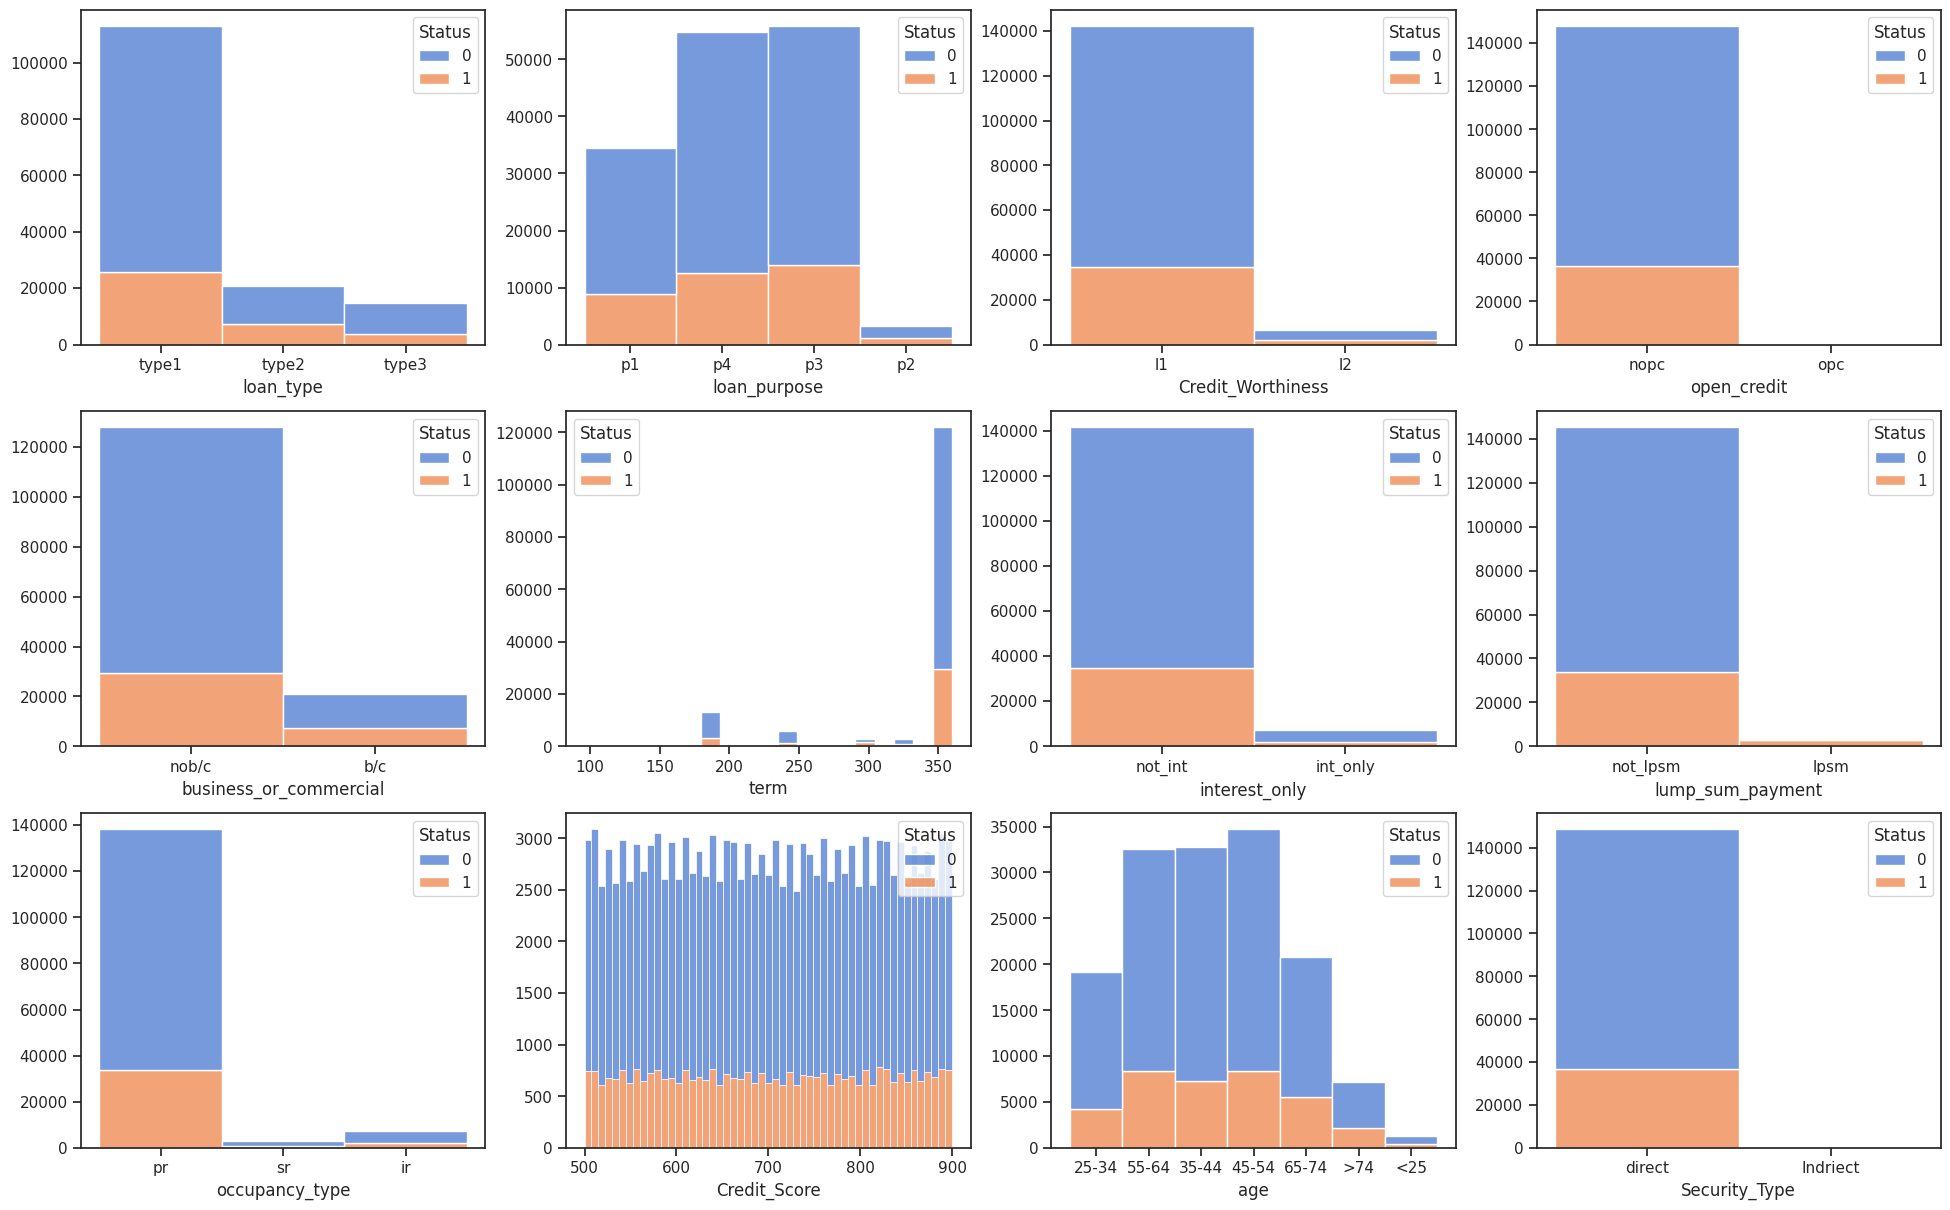

In [10]:
# Distribution of group 1

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

sns.set_theme(style="ticks", palette="muted")
f1 = plt.figure(figsize=(24,20))
for col in input_1:
    i = input_1.index(col) + 1
    ax = f1.add_subplot(4,4,i)
    g1 = sns.histplot(loan, x=loan[col], legend=True, hue='Status', multiple='stack')
    g1.set(ylabel=None)

In [11]:
print(loan.groupby(by=['Status','Security_Type'])['Status'].count())
print(loan.groupby(by=['Status','open_credit'])['Status'].count())

Status  Security_Type
0       direct           112031
1       Indriect             33
        direct            36605
Name: Status, dtype: int64
Status  open_credit
0       nopc           111573
        opc               458
1       nopc            36540
        opc                98
Name: Status, dtype: int64


***Credit_Score*** does not seem to have a remarkable impact to default. Across all levels, the ratio of defaults/non-defaults is fairly stable. ***Open Credit***, ***Security Type***, ***Credit Worthiness***, and ***Occupancy Type*** are not very helpful because there are no (or almost no) records with open credit or indirect security, respectively. We can remove these features from the dataset.

In [12]:
# Remove these features

loan = loan.drop(['open_credit', 'Security_Type', 'Credit_Score', 'occupancy_type', 'Credit_Worthiness'], axis=1)


**Group 2**

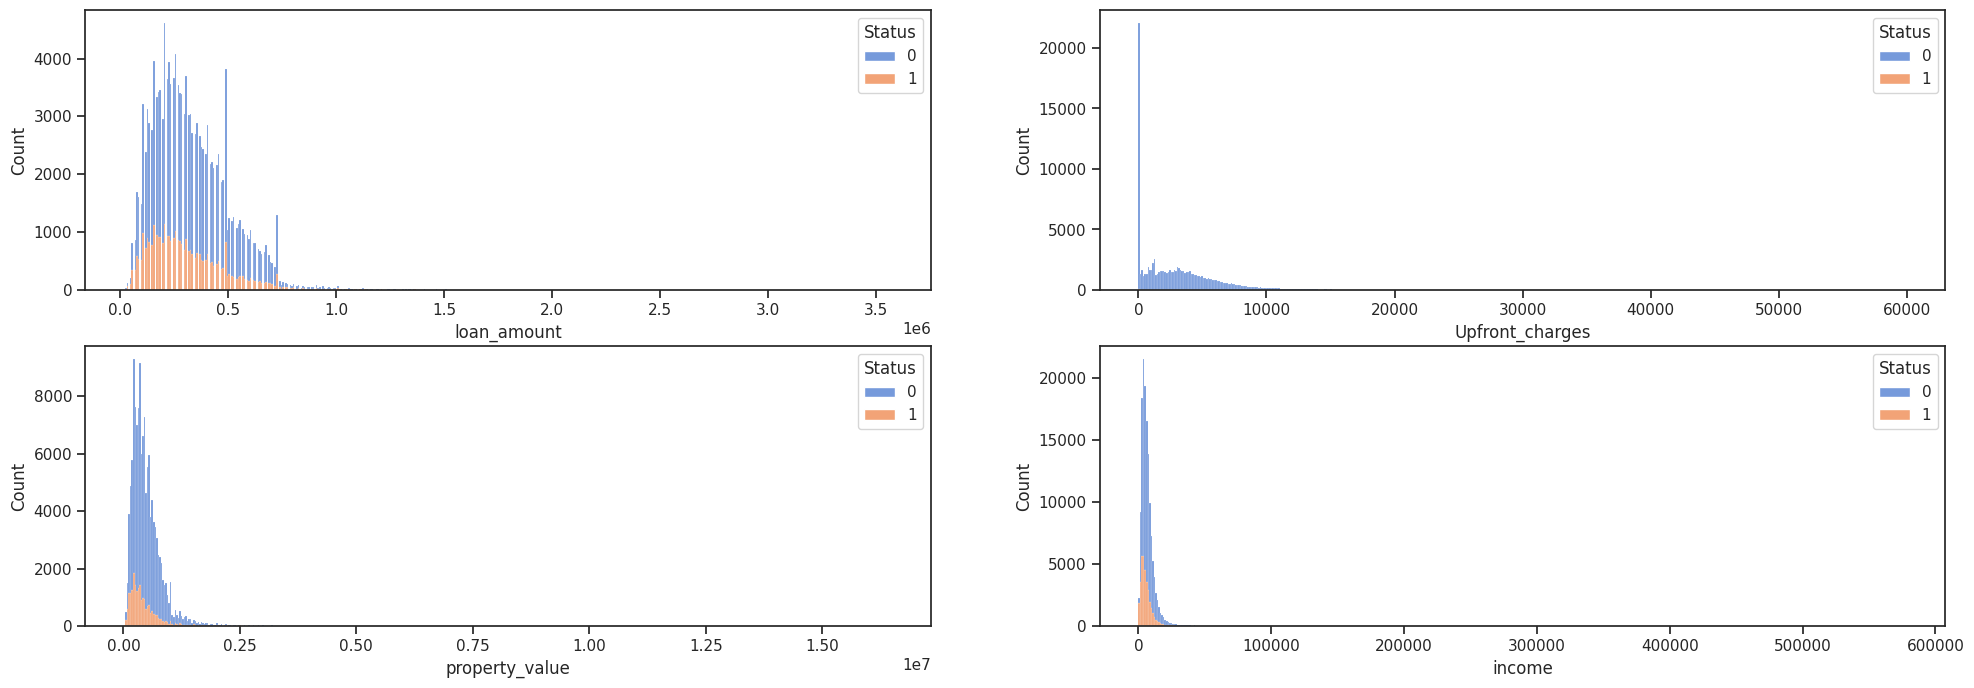

In [13]:
# Distribution of group 2 

f2 = plt.figure(figsize=(24,8))
for col in input_2:
    i = input_2.index(col) + 1
    ax = f2.add_subplot(2,2,i)
    g2 = sns.histplot(loan, x=loan[col], legend=True, hue='Status', multiple='stack', bins=500)

## Property Value

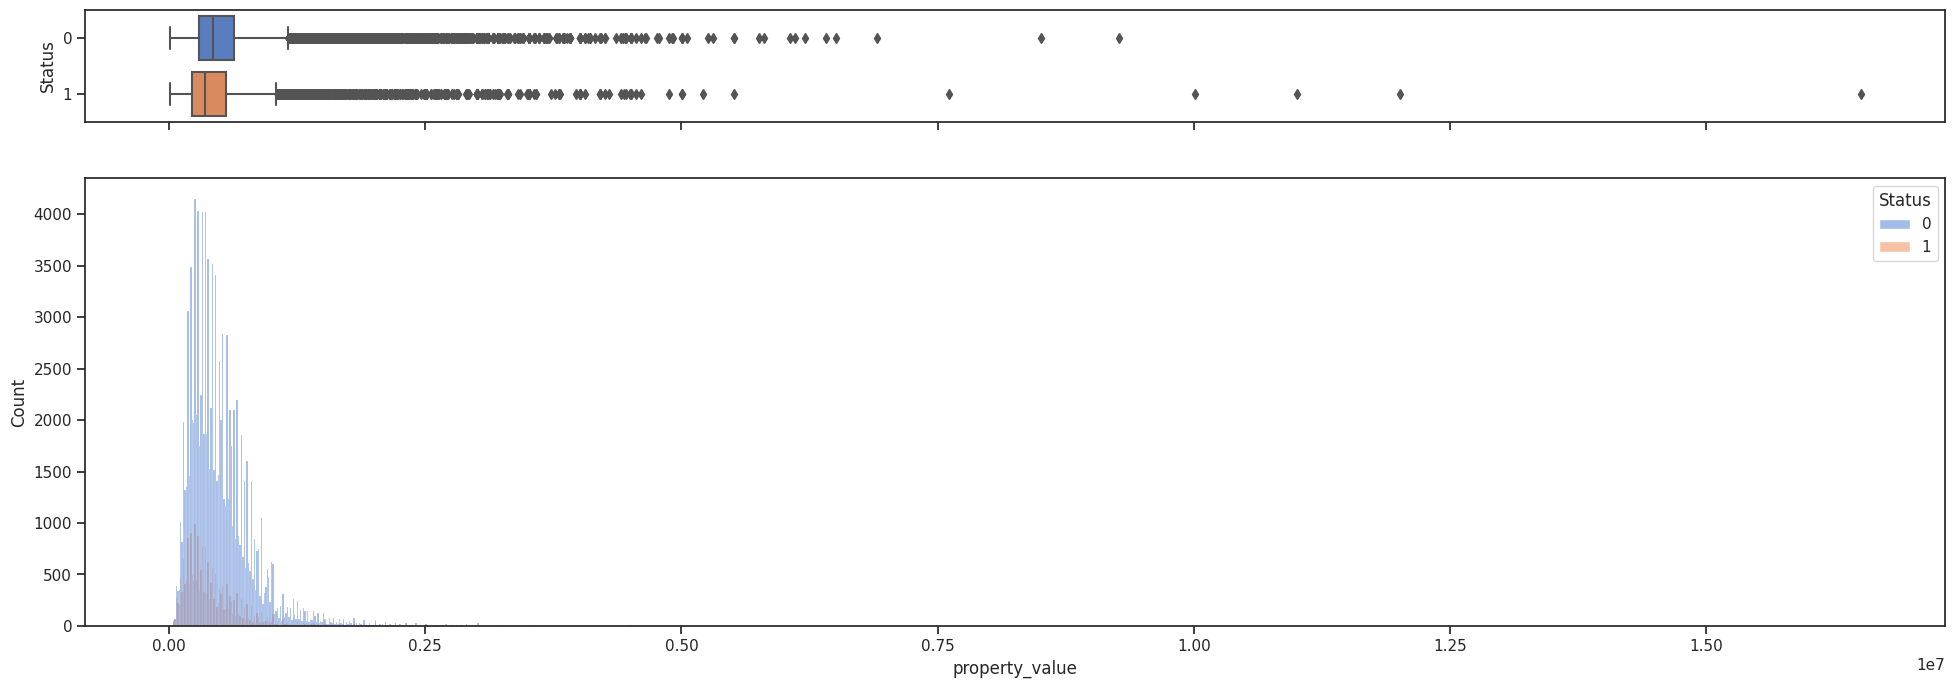

In [14]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)},figsize=(24,8))
 
# assigning a graph to each ax
sns.boxplot(loan, x='property_value', y='Status', orient='h', ax=ax_box)
sns.histplot(loan, x='property_value', hue='Status', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

In [15]:
pv = loan['property_value']
pv2 = pv.value_counts().sort_values(ascending=False)
pv2.head(10)

property_value
308000.0    2792
258000.0    2763
358000.0    2679
408000.0    2537
328000.0    2524
278000.0    2513
268000.0    2497
228000.0    2493
238000.0    2408
288000.0    2398
Name: count, dtype: int64

Hmmm... it looks like property value was increased by 8000 for each record. 

In [16]:
pv1 = pv - 8000
pv1.mod(10000).sum()

0.0

Yes, it's true that we have some noise in property value. I can't think of any practical reason for the bank to do so, maybe it was made by the author of the dataset. We will need to adjust property value down by 8000. Some records will have a property value of 0 accordingly, affecting LTV when we recalculate it.
> We will need to adjust property value down by 8000. 

## Loan amount

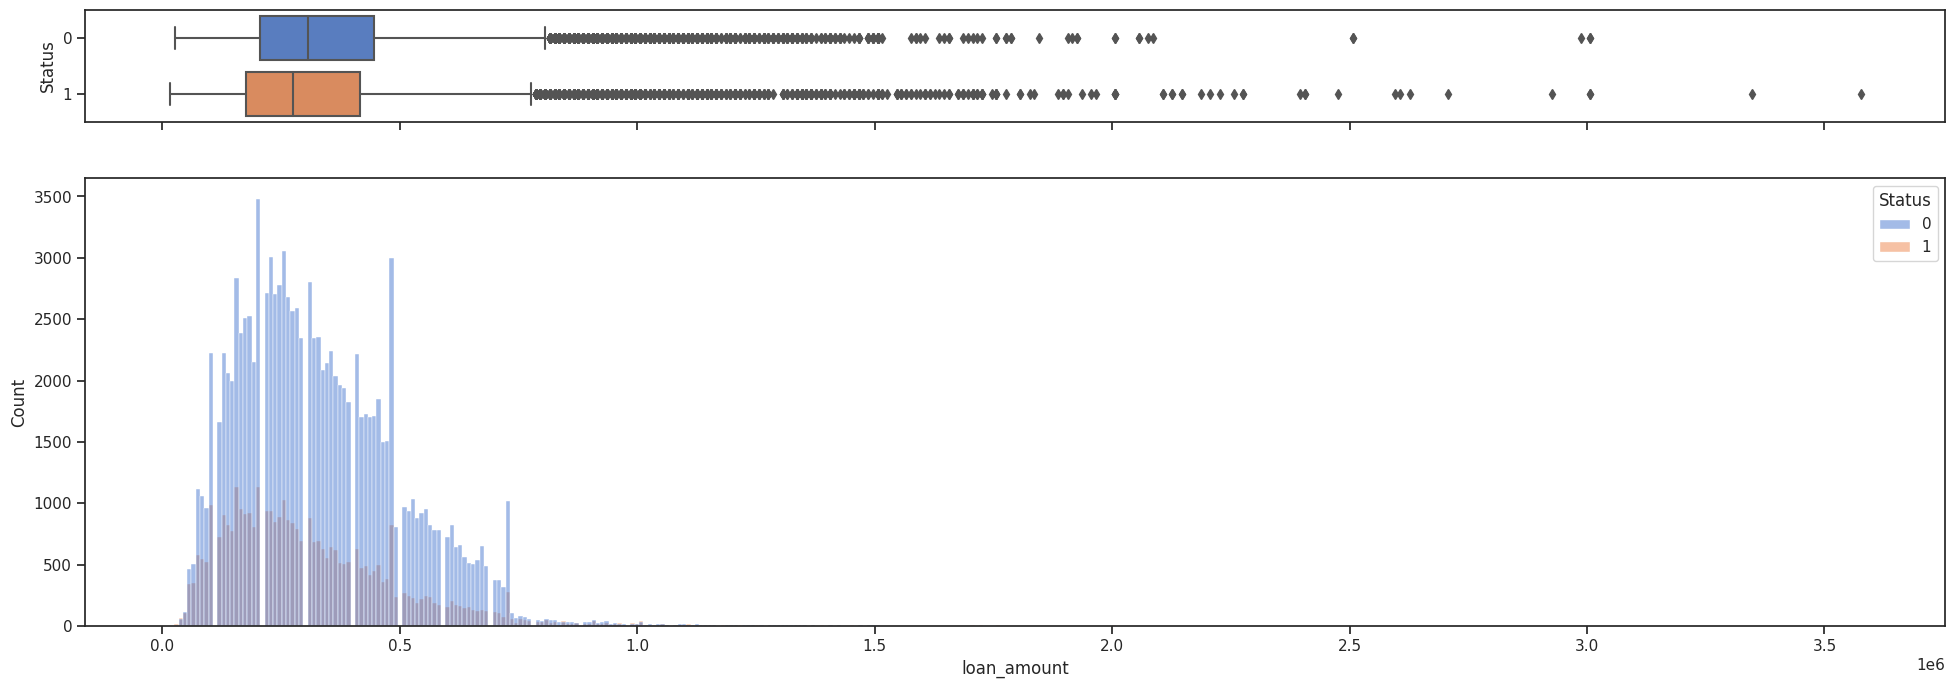

In [17]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.2, .8)},figsize=(24,8))
 
# assigning a graph to each ax
sns.boxplot(loan, x='loan_amount', y='Status', orient='h', ax=ax_box)
sns.histplot(loan, x='loan_amount', hue='Status', ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

Why are there some gaps at an interval? Let's take a closer look.

<Axes: >

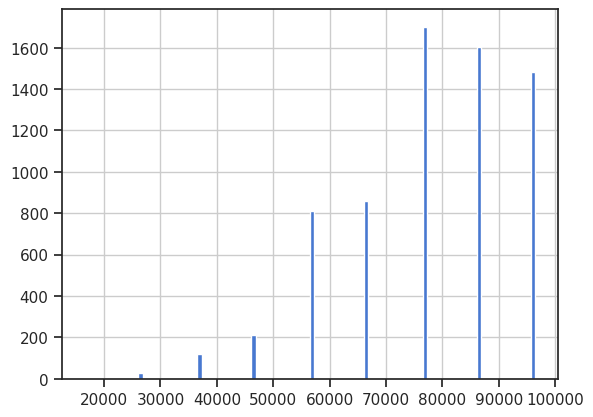

In [18]:
loan1 = loan[loan['loan_amount']<100000]
loan1['loan_amount'].hist(bins=100)

In [19]:
loan1['loan_amount']

15        76500
55        86500
89        56500
95        76500
171       86500
          ...  
148503    66500
148504    76500
148514    76500
148558    86500
148652    96500
Name: loan_amount, Length: 6820, dtype: int64

In [20]:
ln = loan['loan_amount']
ln1 = ln - 6500
ln1.mod(10000).sum()

0

Again, there are noise in loan amount. The loan amount of each record was increased by 6500 (or decreased by 3500).
> We will adjust loan amount by reducing the amount by 6500.

**Group 3**

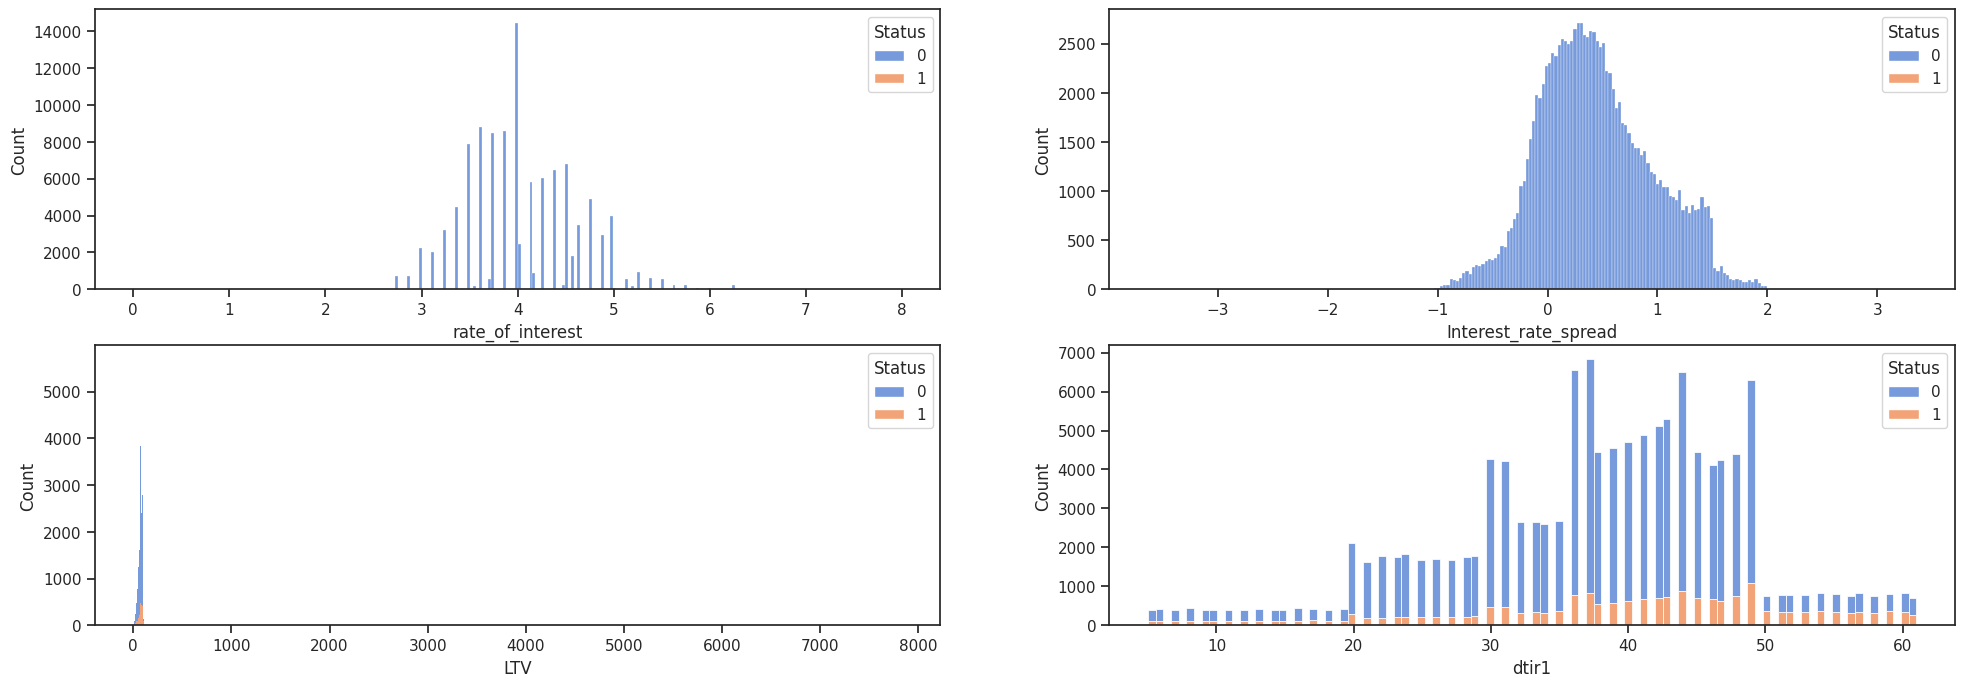

In [21]:
# Distribution of group 3

f3 = plt.figure(figsize=(24,8))
for col in input_3:
    i = input_3.index(col) + 1
    ax = f3.add_subplot(2,2,i)
    g2 = sns.histplot(loan, x=loan[col], legend=True, hue='Status', multiple='stack', )

## LTV

Borrowers' application could be approved with properties less or more valuable than the loan amount. However, it's very rare if the bank would accept a mortgage loan that is higher than 80% of the property value ([source](https://www.wsj.com/buyside/personal-finance/mortgage/loan-to-value-ratio)).

In [22]:
loan[loan['LTV']>0.8].sort_values(by='LTV')

,loan_type,loan_purpose,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,interest_only,lump_sum_payment,property_value,income,age,LTV,Status,dtir1
42558,type1,p3,nob/c,106500,NaN,NaN,NaN,360.0,int_only,not_lpsm,11008000.0,67020.0,45-54,0.967478,1,20.0
110510,type1,p3,nob/c,66500,4.750,0.3520,NaN,360.0,int_only,not_lpsm,3208000.0,11880.0,45-54,2.072943,0,31.0
124997,type1,p3,nob/c,256500,5.490,1.2420,NaN,360.0,int_only,not_lpsm,9268000.0,33360.0,65-74,2.767587,0,31.0
89,type1,p3,nob/c,56500,4.500,0.2520,NaN,360.0,int_only,not_lpsm,2008000.0,7980.0,65-74,2.813745,0,41.0
66732,type1,p3,nob/c,56500,6.240,1.0820,NaN,360.0,int_only,not_lpsm,1978000.0,7200.0,>74,2.856421,0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46287,type2,p4,b/c,236500,NaN,NaN,NaN,360.0,not_int,not_lpsm,8000.0,NaN,45-54,2956.250000,1,NaN
65238,type2,p4,b/c,376500,3.750,1.0204,0.0,360.0,not_int,not_lpsm,8000.0,NaN,45-54,4706.250000,0,NaN
47807,type2,p4,b/c,416500,3.500,0.7882,0.0,360.0,not_int,not_lpsm,8000.0,NaN,35-44,5206.250000,0,NaN
55286,type2,p4,b/c,536500,3.750,1.0404,0.0,360.0,not_int,not_lpsm,8000.0,NaN,45-54,6706.250000,0,NaN


 Looking at the data in LTV column, it seems that they were incorrectly denoted in percentage without the % symbol or were due to incorrect property value. 

> Thus, we will need to recalculte LTV.

## Bivariate Analysis

Next, we will look at the linear relationship between the numerical features.

In [23]:
# Calculate correlations
num_var = []
for col in loan.columns:
    if loan[col].dtypes != object:
        num_var.append(col)

corr = loan[num_var].corr()

print('Top 5 pairs with strongest positive correlations:')
print('-------------------------------------------------')
print(corr.unstack().sort_values(ascending=False, kind="quicksort").drop_duplicates()[1:6])

print(' \n')
print('Top 5 pairs with strongest negative correlations:')
print('-------------------------------------------------')
print(corr.unstack().sort_values(ascending=False, kind="quicksort").drop_duplicates()[-6:-1])

Top 5 pairs with strongest positive correlations:
-------------------------------------------------
loan_amount       property_value          0.734249
rate_of_interest  Interest_rate_spread    0.614908
income            loan_amount             0.456063
                  property_value          0.414883
rate_of_interest  term                    0.209330
dtype: float64
 

Top 5 pairs with strongest negative correlations:
-------------------------------------------------
term                  Interest_rate_spread   -0.157139
LTV                   property_value         -0.215102
income                dtir1                  -0.267807
Interest_rate_spread  property_value         -0.334571
loan_amount           Interest_rate_spread   -0.377272
dtype: float64


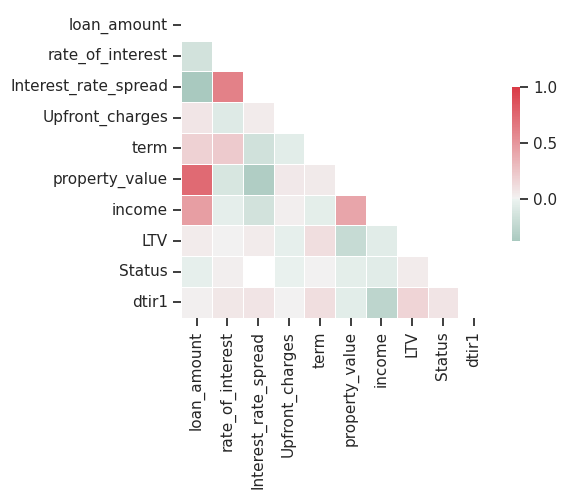

In [24]:
# Visualization of correlations using a heatmap

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(6, 4))
cmap = sns.diverging_palette(-200, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The correlations among these features make senses economically and statistically.

# Imputation
-----

## Data denoising

In [25]:
# 1. Reduce the property value of all records by 8000
loan['property_value1'] = loan['property_value'] - 8000

# 2. Reduce the loan amount of all records by 6500
loan['loan_amount1'] = loan['loan_amount'] - 6500

## Handling missing data

- For categorical features: decoding with a new category "missing".
- For numerical features: using KNN method to impute missing data.
- For LTV and DTIR: recalculating from income, loan amount, and property value.


### Decoding categorical features

In [26]:
cat = [col for col in loan.columns if loan[col].dtype == 'object'] 
loan[cat] = loan[cat].fillna('Missing')

In [27]:
loan[cat].isna().sum()

loan_type                 0
loan_purpose              0
business_or_commercial    0
interest_only             0
lump_sum_payment          0
age                       0
dtype: int64

### Using KNN for numerical features

In [28]:
# pip install -U scikit-learn
from sklearn.impute import KNNImputer
num = [col for col in loan.columns if loan[col].dtype != 'object']
to_remove = ['Status', 'LTV', 'property_value', 'loan_amount']
num = [col for col in num if col not in to_remove]

In [29]:
knn = KNNImputer(n_neighbors = 3)
knn.fit(loan[num])
transformed = knn.transform(loan[num])
transformed = pd.DataFrame(transformed,columns=num)
loan[num] = transformed[num]
loan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148669 entries, 0 to 148669
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_type               148669 non-null  object 
 1   loan_purpose            148669 non-null  object 
 2   business_or_commercial  148669 non-null  object 
 3   loan_amount             148669 non-null  int64  
 4   rate_of_interest        148668 non-null  float64
 5   Interest_rate_spread    148668 non-null  float64
 6   Upfront_charges         148668 non-null  float64
 7   term                    148668 non-null  float64
 8   interest_only           148669 non-null  object 
 9   lump_sum_payment        148669 non-null  object 
 10  property_value          133572 non-null  float64
 11  income                  148668 non-null  float64
 12  age                     148669 non-null  object 
 13  LTV                     133572 non-null  float64
 14  Status                  1

### Recalculating LTV

In [30]:
# Recalculate LTV
loan['LTV_1'] = loan['loan_amount1'] / loan['property_value1'] * 100

# Export Cleaned Dataset

In [31]:
loan_clean = loan.drop(['loan_amount', 'property_value', 'LTV'], axis=1)
loan_clean = loan_clean.dropna(axis=0, how='any')
loan_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148668 entries, 0 to 148668
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_type               148668 non-null  object 
 1   loan_purpose            148668 non-null  object 
 2   business_or_commercial  148668 non-null  object 
 3   rate_of_interest        148668 non-null  float64
 4   Interest_rate_spread    148668 non-null  float64
 5   Upfront_charges         148668 non-null  float64
 6   term                    148668 non-null  float64
 7   interest_only           148668 non-null  object 
 8   lump_sum_payment        148668 non-null  object 
 9   income                  148668 non-null  float64
 10  age                     148668 non-null  object 
 11  Status                  148668 non-null  int64  
 12  dtir1                   148668 non-null  float64
 13  property_value1         148668 non-null  float64
 14  loan_amount1            1

In [32]:
loan_clean.to_csv('/kaggle/working/Loan_Clean_Data.csv')

-----
Thank you for reading! Please comment and vote if you find it helpful :) 